In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb



In [2]:
# Load dataset
file_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())



   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
# ---- Data Preprocessing ---- #

# Drop 'customerID' column as it's not useful for prediction
df.drop(columns=['customerID'], inplace=True)

# Convert 'TotalCharges' to numeric (some values are blank and appear as strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values in 'TotalCharges' with the median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

<ipython-input-3-563985904e3d>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [4]:
# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Define features and target variable
X = df.drop('Churn', axis=1)  # Features
y = df['Churn']  # Target

In [5]:
# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [6]:
# ---- Model Training with XGBoost ---- #

# Define XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model
xgb_clf.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [7]:
# Predictions
y_pred = xgb_clf.predict(X_test)



In [8]:
# ---- Evaluation ---- #
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.7913
Precision: 0.6242
Recall: 0.5374
F1 Score: 0.5776


In [9]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



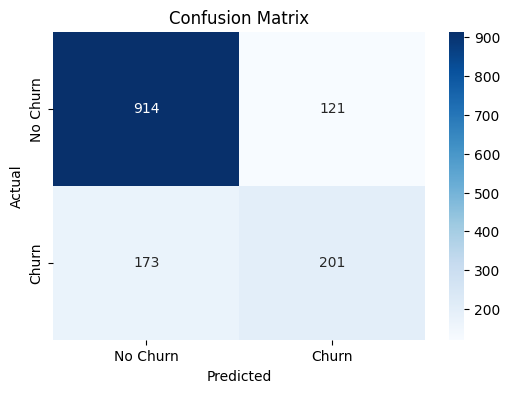

In [10]:
#---- Visualizations ---- #

# Confusion Matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



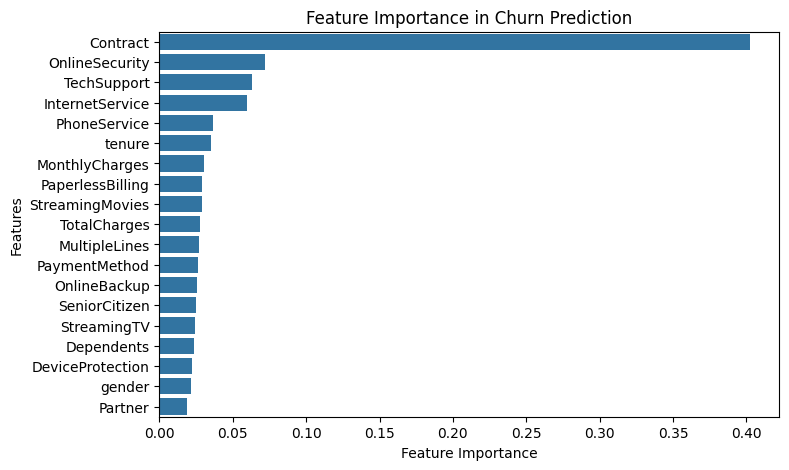

In [11]:
# Feature Importance
feature_importance = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Churn Prediction")
plt.show()

<ipython-input-12-15553ea14aa5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=["green", "red"])


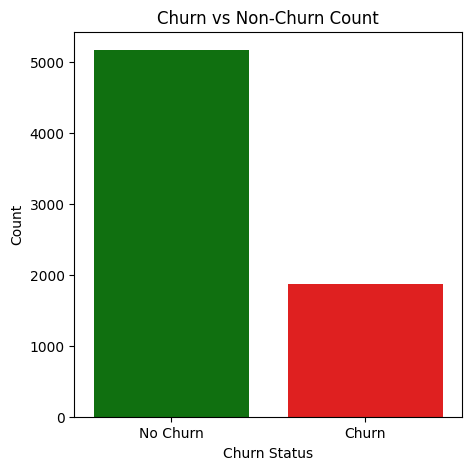

In [12]:
# Churn vs Non-Churn Count (Bar Graph)
plt.figure(figsize=(5, 5))
sns.countplot(x=y, palette=["green", "red"])
plt.xticks(ticks=[0, 1], labels=["No Churn", "Churn"])
plt.xlabel("Churn Status")
plt.ylabel("Count")
plt.title("Churn vs Non-Churn Count")
plt.show()




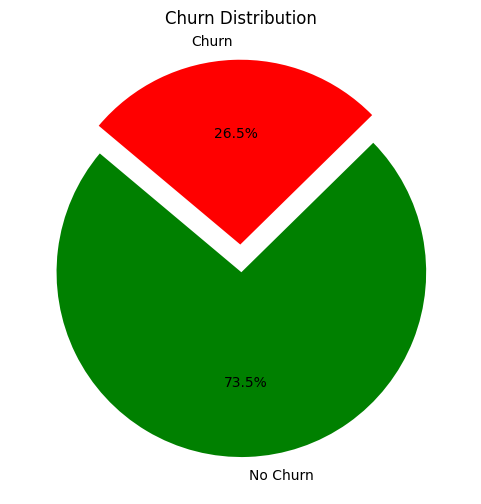

In [13]:
# Class Distribution (Pie Chart)
plt.figure(figsize=(6, 6))
labels = ['No Churn', 'Churn']
colors = ['green', 'red']
plt.pie(y.value_counts(), labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, explode=[0.05, 0.1])
plt.title("Churn Distribution")
plt.show()



<ipython-input-14-3f9f5c93bb91>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="Blues")


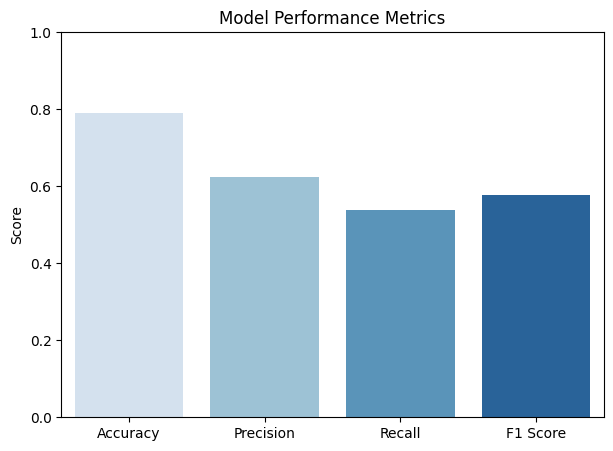

In [14]:
#Model Performance (Bar Chart)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7, 5))
sns.barplot(x=metrics, y=values, palette="Blues")
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
param_grid = {
       'n_estimators': [100, 200, 300],
       'learning_rate': [0.01, 0.1, 0.2],
       'max_depth': [3, 4, 5],
       'subsample': [0.7, 0.8, 0.9],
       'colsample_bytree': [0.7, 0.8, 0.9]
   }

In [17]:
grid_search = GridSearchCV(estimator=xgb_clf,
                              param_grid=param_grid,
                              scoring='accuracy',  # You can use other metrics like 'f1', 'precision', etc.
                              cv=5,  # Number of cross-validation folds
                              n_jobs=-1)  # Use all available CPU cores

In [18]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, ma...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy')

In [19]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}


Accuracy: 0.8084
Precision: 0.6757
Recall: 0.5348
F1 Score: 0.5970

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.53      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



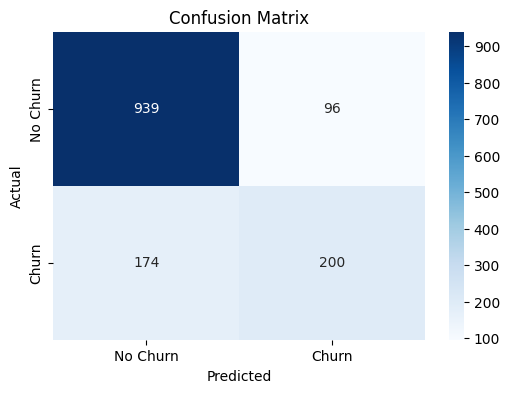

In [21]:
# ---- Evaluation with Best Hyperparameters ---- #
# Get the best model from GridSearchCV
best_xgb_clf = grid_search.best_estimator_

# Predictions with the best model
y_pred = best_xgb_clf.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<ipython-input-22-632bcb532fb4>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


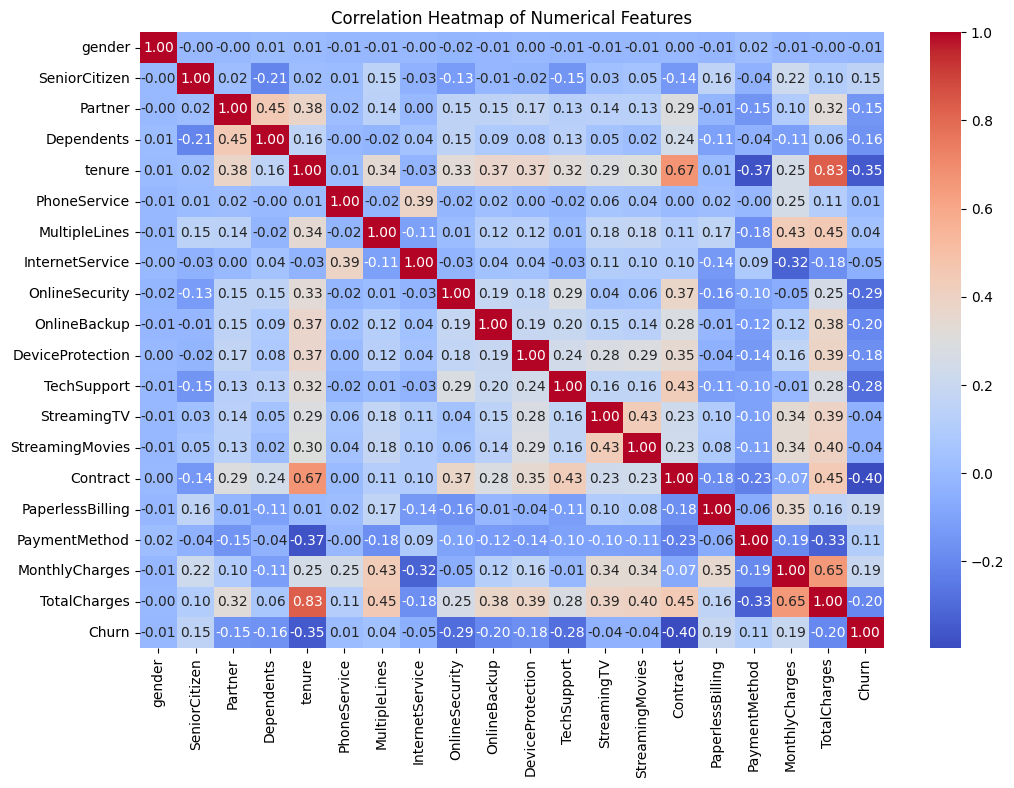

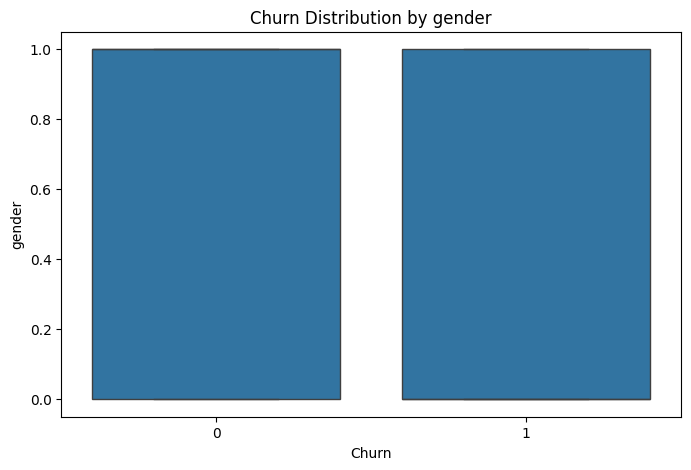

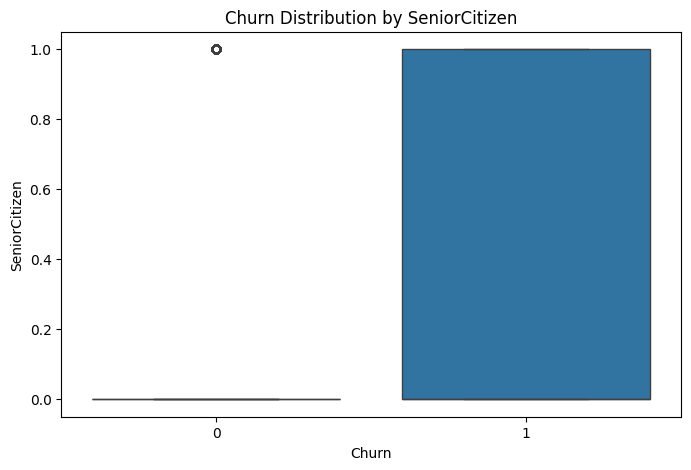

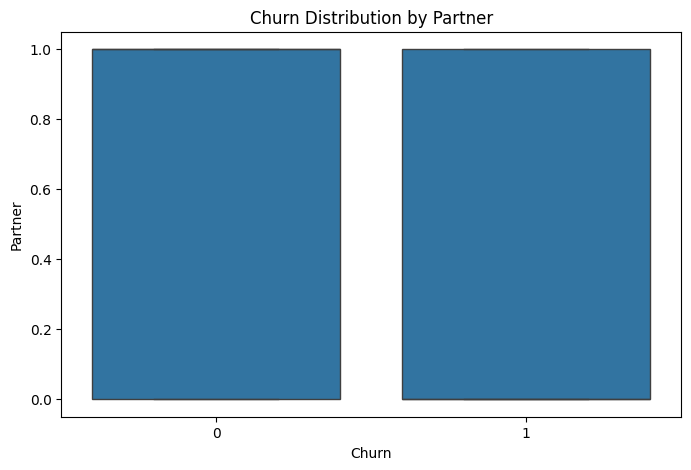

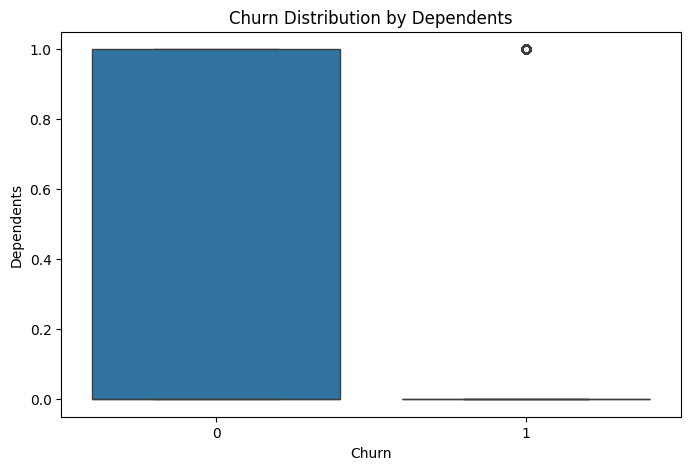

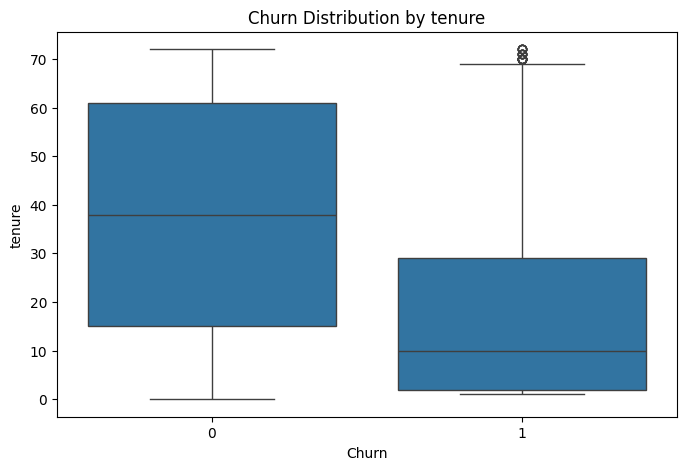

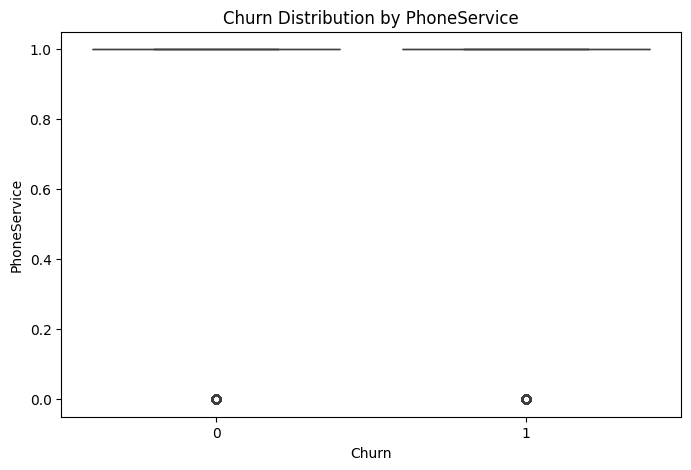

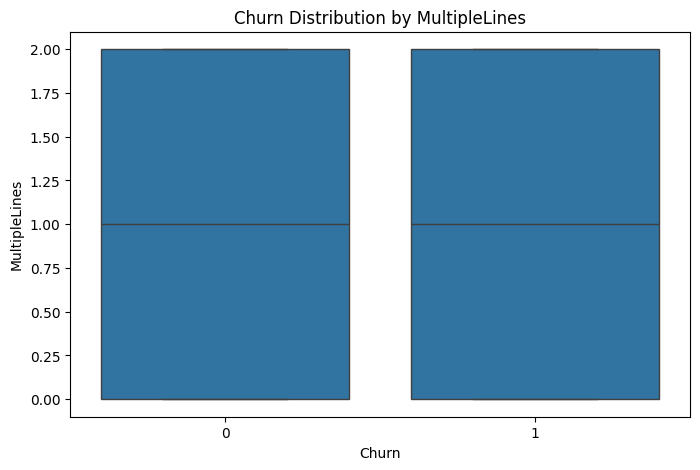

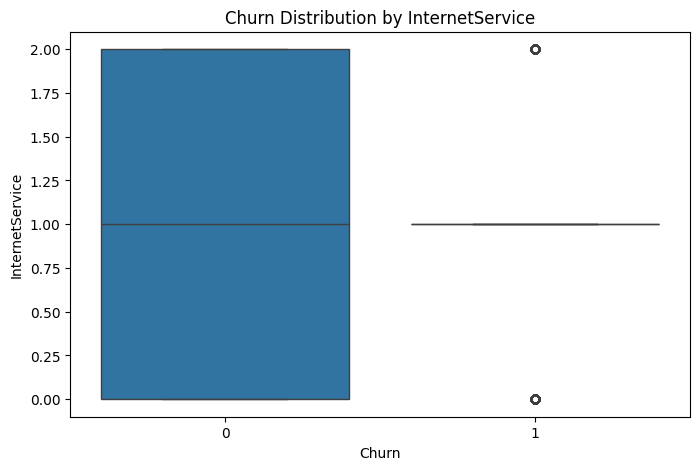

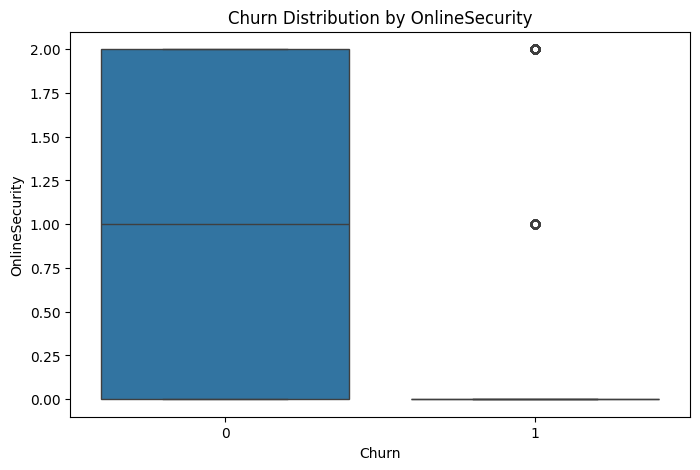

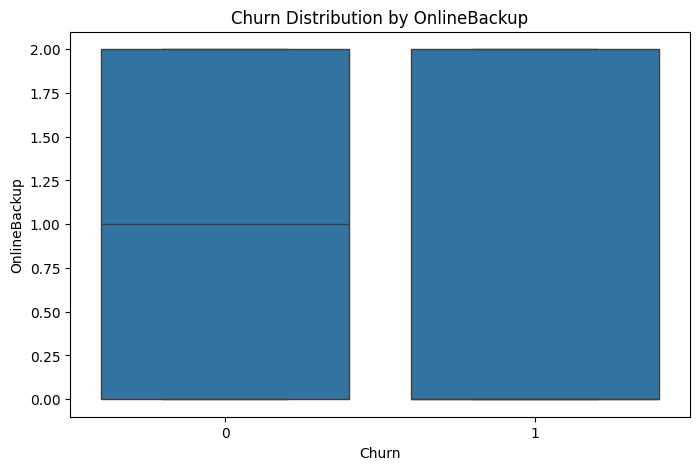

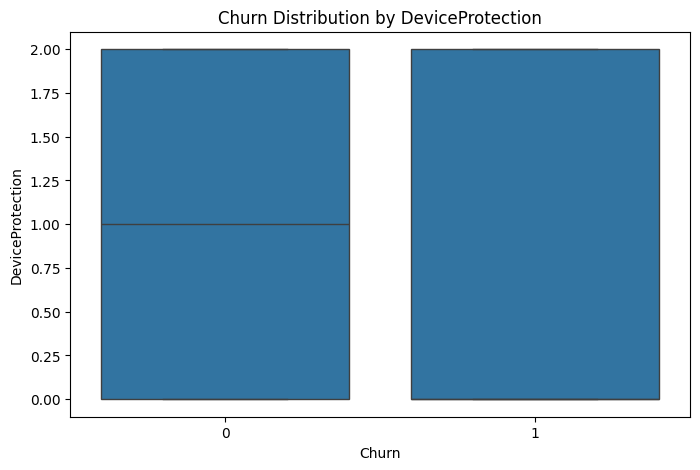

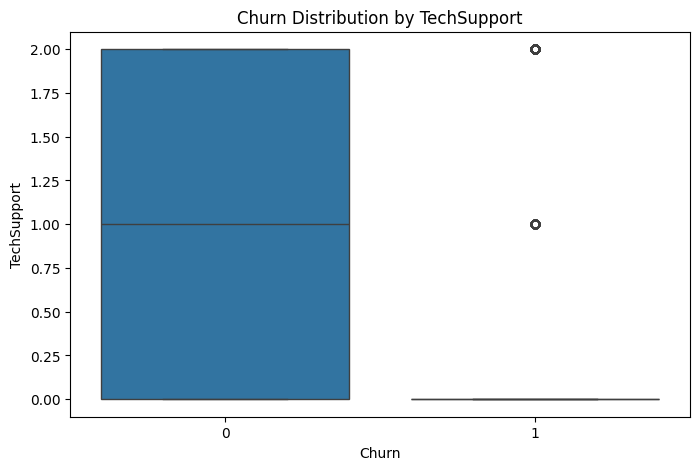

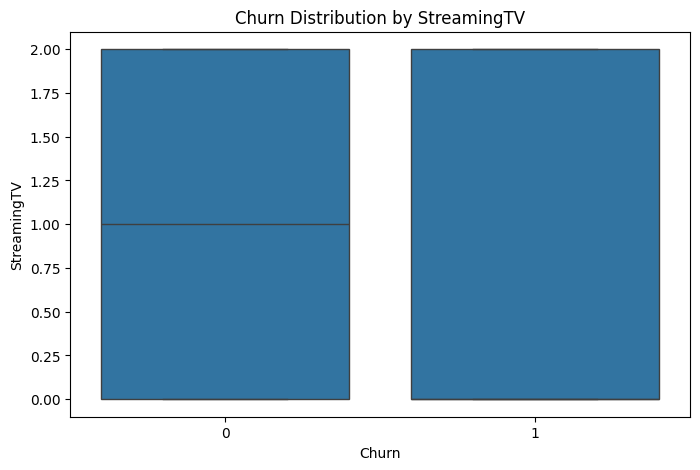

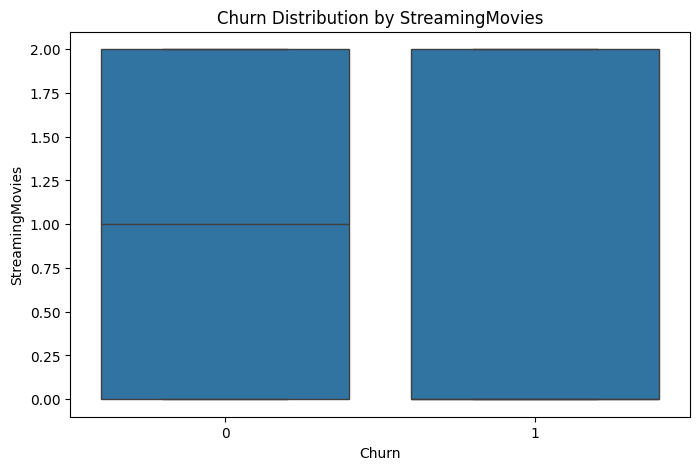

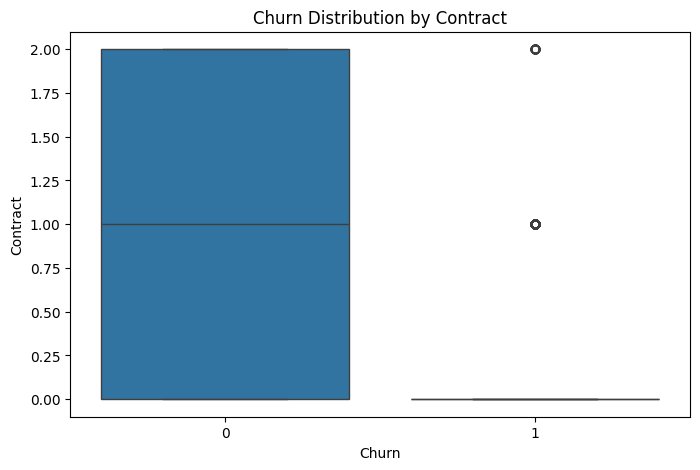

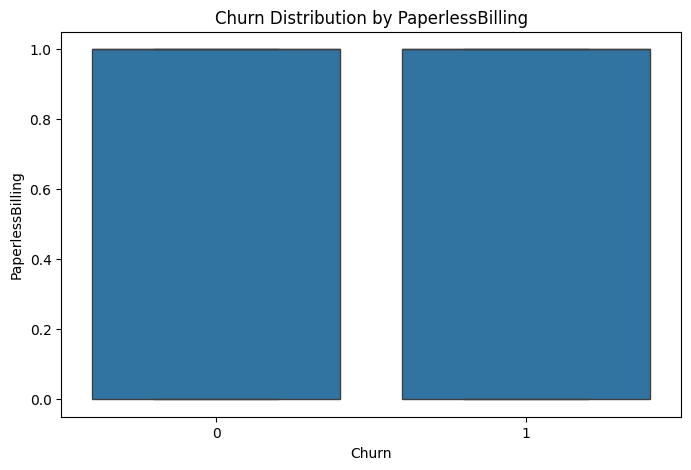

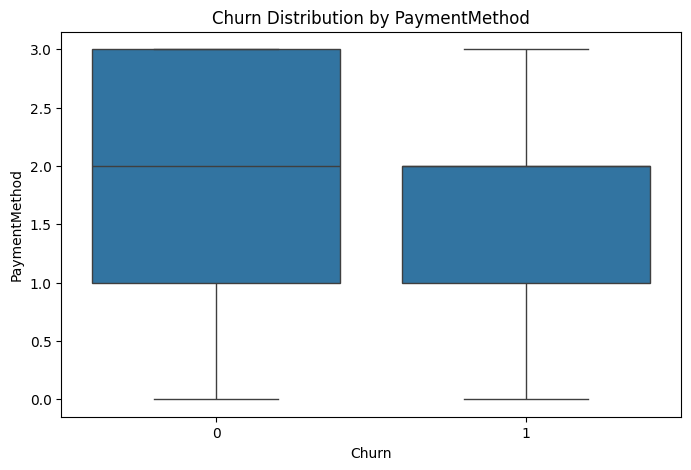

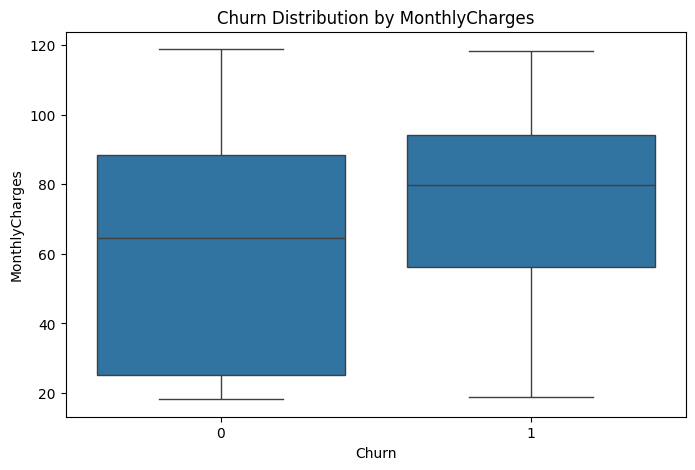

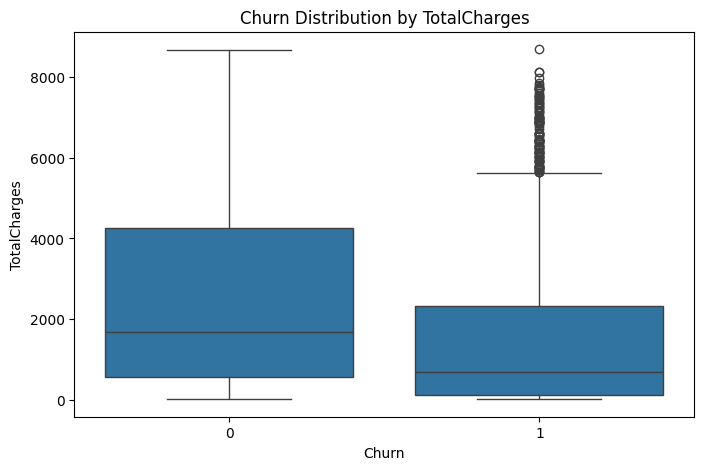

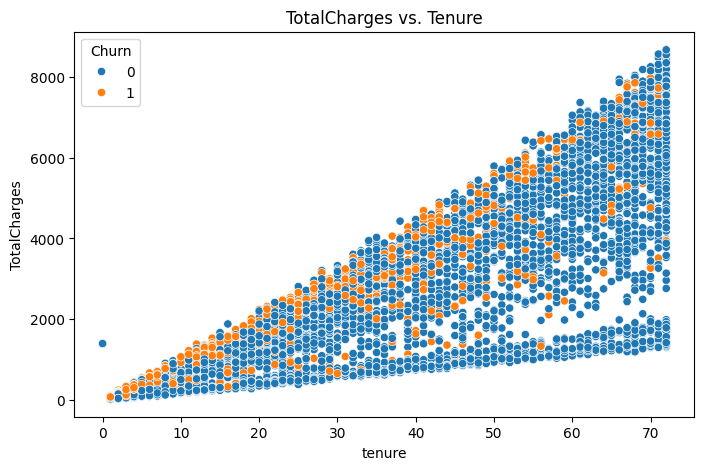

In [22]:

# Convert 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values in 'TotalCharges' with the median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# --- Relationship visualizations ---

# 1. Correlation Heatmap (for numerical features)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# 2. Churn vs. Categorical Features (Countplots)
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Churn':  # Exclude the target variable itself
        plt.figure(figsize=(8, 5))
        sns.countplot(x=col, hue='Churn', data=df)
        plt.title(f"Churn Distribution by {col}")
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.show()

# 3. Churn vs. Numerical Features (Boxplots/Violinplots)
for col in df.select_dtypes(include=['number']).columns:
    if col != 'Churn':  # Exclude the target variable itself
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Churn', y=col, data=df)  # Or use sns.violinplot
        plt.title(f"Churn Distribution by {col}")
        plt.show()

# 4. Scatter Plots (for relationships between numerical features)
# Example: TotalCharges vs. tenure
plt.figure(figsize=(8, 5))
sns.scatterplot(x='tenure', y='TotalCharges', hue='Churn', data=df)
plt.title("TotalCharges vs. Tenure")
plt.show()